In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline

rcParams['figure.figsize'] = (15,6)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("D://M_AI//Machine Learning//Demo Datasets//Lesson 8//AirPassengers.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [30]:
df['Month'] = df['Month'].apply(lambda x:dt(int(x[:4]),int(x[5:]),15))
df = df.set_index('Month')
df.head()

,#Passengers
Month,
1949-01-15,112
1949-02-15,118
1949-03-15,132
1949-04-15,129
1949-05-15,121


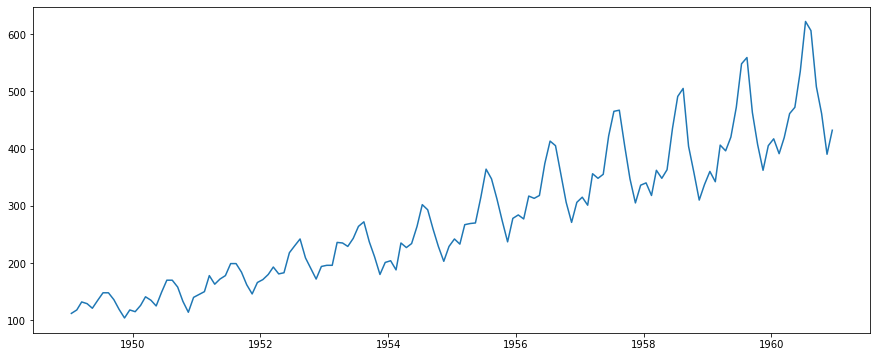

In [31]:
ts =df['#Passengers'] 
plt.plot(ts)

In [32]:
# transforming ts using log decomposition because ts is exponentially increasing
ts_log = np.log(ts)

In [33]:
# stationarity check
def test_stationarity(timeseries):
    rollmean = timeseries.rolling(window=52,center=False).mean()
    rollstd = timeseries.rolling(window=52,center=False).std()
    
    org = plt.plot(timeseries,color='b',label='original')
    mean = plt.plot(rollmean,color='r',label='Rolling mean')
    std = plt.plot(rollstd,color='black',label = 'Rolling standarddeviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)
    
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    

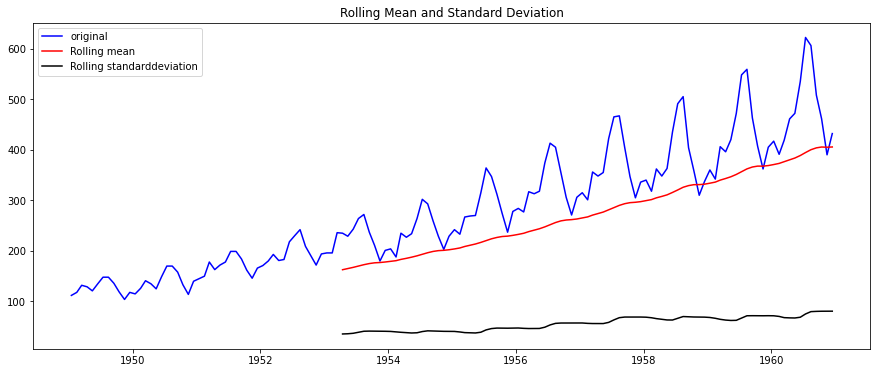

Results of Dickey Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [34]:
test_stationarity(df['#Passengers'])

In [35]:
# as per the graph above the time series data is not stationary and null hypothesis cannot be rejected



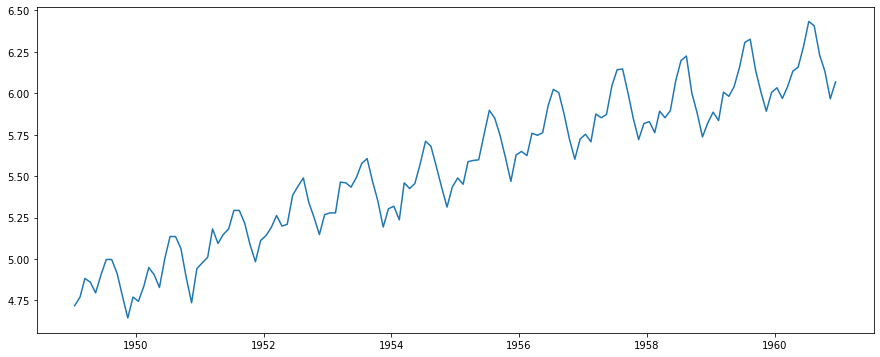

In [36]:
plt.plot(ts_log)

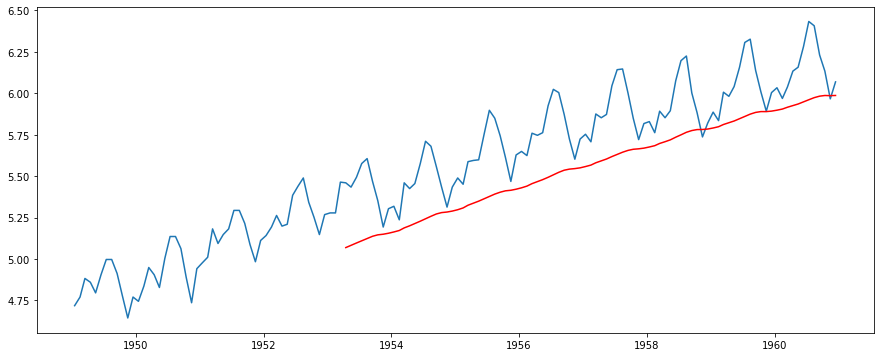

In [37]:
# Calculate moving average and Standard deviation

movingAvg = ts_log.rolling(window = 52,center=False).mean()
movingStd = ts_log.rolling(window = 52,center=False).std()

plt.plot(ts_log)
plt.plot(movingAvg,color='r')

In [38]:
# Differencing
ts_log_mv_diff = ts_log - movingAvg
ts_log_mv_diff.head(12)
ts_log_mv_diff.dropna(inplace=True)

ts_log_mv_diff.head(10)

Month
1953-04-15    0.390598
1953-05-15    0.350980
1953-06-15    0.396428
1953-07-15    0.465985
1953-08-15    0.481492
1953-09-15    0.330822
1953-10-15    0.206032
1953-11-15    0.043367
1953-12-15    0.147828
1954-01-15    0.154846
Name: #Passengers, dtype: float64

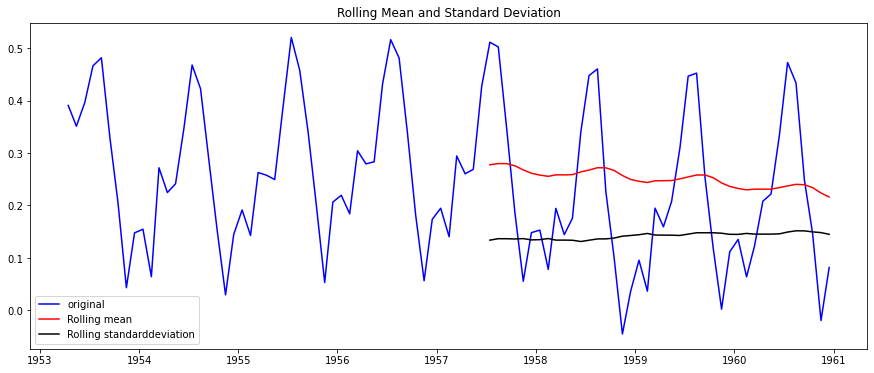

Results of Dickey Fuller Test:
Test Statistic                 -0.752629
p-value                         0.832643
#Lags Used                     12.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64


In [39]:
test_stationarity(ts_log_mv_diff)

In [40]:
# the fuller test shows that the test statistic is less than 1% critical value 
# which  tells us that the this series is 99% stationary

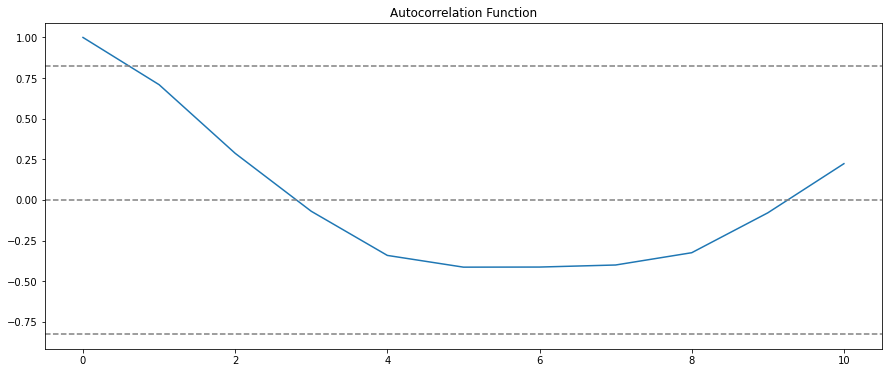

In [41]:
# plotting acf 
plt.plot(np.arange(0,11),acf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,color='gray',linestyle='--')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),color='gray',linestyle='--')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),color='gray',linestyle='--')
plt.title('Autocorrelation Function')
plt.show()

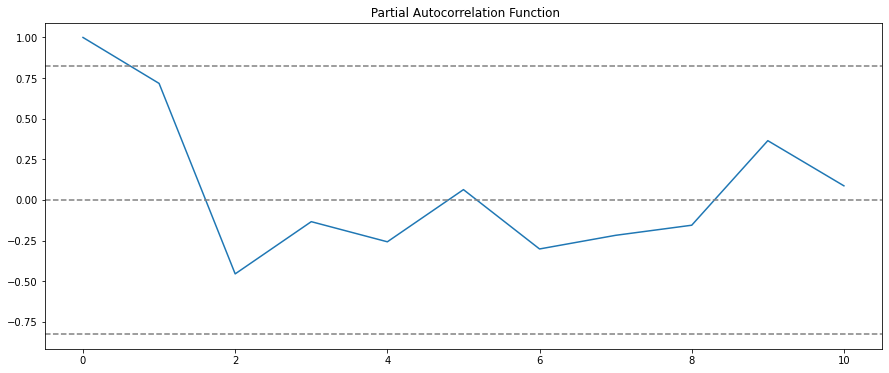

In [42]:
# plotting pacf 
plt.plot(np.arange(0,11),pacf(ts_log_mv_diff,nlags=10))
plt.axhline(y=0,color='gray',linestyle='--')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),color='gray',linestyle='--')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),color='gray',linestyle='--')
plt.title(' Partial Autocorrelation Function')
plt.show()

In [43]:
# the plot crosseszero between 1 and 2 , so the optimal value is between 1 or 2 

Text(0.5, 1.0, 'RSS : nan')

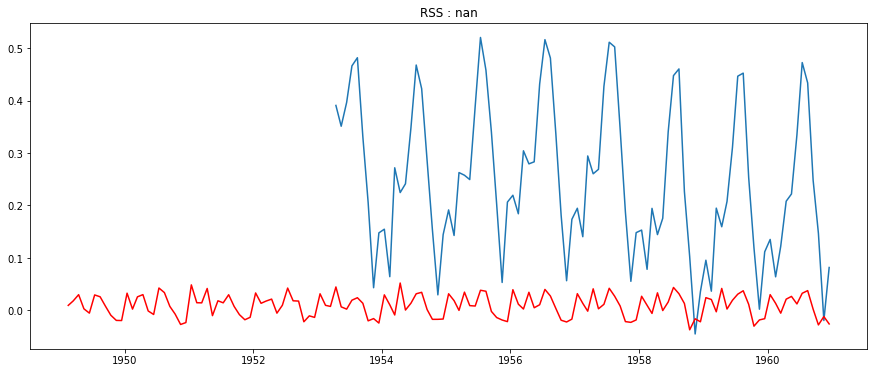

In [44]:
# build ARIMA model
model = ARIMA(ts_log,order=(1,1,0))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_log_mv_diff)
plt.plot(results_ARIMA.fittedvalues,color='r')
plt.title('RSS : %.4f'%sum((results_ARIMA.fittedvalues[1:]-ts_log_mv_diff)**2))

In [45]:
# storing the predicted values in Series
pred_ARIMA_diff_results = pd.Series(results_ARIMA.fittedvalues, copy = True)
pred_ARIMA_diff_results.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [46]:
# converting differencing values to log scale values by adding the consecutive differences to base number
pred_ARIMA_cumsum = pred_ARIMA_diff_results.cumsum()
pred_ARIMA_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [48]:
pred_ARIMA_log = pd.Series(ts_log.iloc[0], index = ts_log.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_ARIMA_cumsum,fill_value=0)
pred_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5, 1.0, 'RMSE: 52.1841')

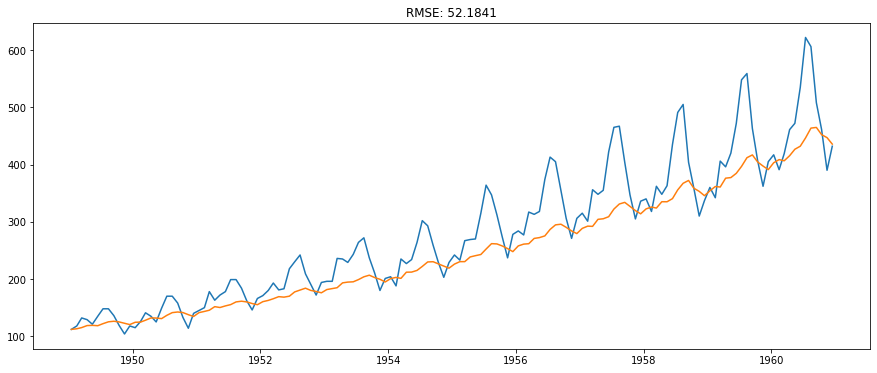

In [51]:
# Calculate forecasts
pred_ARIMA = np.exp(pred_ARIMA_log)
plt.plot(ts)
plt.plot(pred_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((pred_ARIMA-ts)**2)/len(ts)))